In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, BertForTokenClassification

from model_trainer import GeneralModelTrainer

from blstm.dataset import TextDataset
from blstm.lstm_token_classifier import LSTMTokenClassifier
from blstm.utils import create_glove_matrix
# from blstm.model_trainer import ModelTrainer

from bert.bert_dataset import BertTextDataset
# from bert.bert_trainer import ModelTrainer
# from bert.bert_for_token_classification_weighted import BertForTokenClassificationWeighted

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = './data'
weights_dir = './weights'
device = 'cuda'
max_line_len = 150
# batch_size = 128  # BERT
batch_size = 1024

In [3]:
train_dataset = TextDataset(base_path=data_dir,
                            split_name='train_small',
                            max_len=max_line_len)

vocab = train_dataset.get_vocab()

val_dataset = TextDataset(base_path=data_dir,
                          split_name='dev',
                          max_len=max_line_len,
                          vocab=vocab)

# train_dataset = BERTTextDataset(base_path=data_dir,
#                                 split_name='train',
#                                 max_len=max_line_len)

# val_dataset = BERTTextDataset(base_path=data_dir,
#                               split_name='dev',
#                               max_len=max_line_len)

[DATASET] Maximum line length: 150
[DATASET] Vocabulary size: 18928
[DATASET] Maximum line length: 150
[DATASET] Vocabulary size: 18928


In [4]:
train_sampler = RandomSampler(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=6)

val_sampler = SequentialSampler(val_dataset)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        sampler=val_sampler,
                        num_workers=6)

In [5]:
len(train_loader)

261

In [5]:
for batch in train_loader:
    batch_lines, batch_labels, batch_masks = batch
    print(batch_lines[10])
    print(batch_labels[10])
    print(batch_masks[10])
    break

tensor([  25,  136, 2651,  812,    8,   13,  808,   12,  141, 1967,   25, 2627,
        8703,   16,  356, 1726,    3,  497,  473,  471, 1256,   12,   13,  655,
         311,    3,   13,  555,  384,   27,   19,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

### LSTM model

In [5]:
word2id = train_dataset.word2id
pretrained_embeddings = create_glove_matrix('../glove.6B/glove.6B.100d.txt',
                                                word2id,
                                                embed_dim=100)

model = LSTMTokenClassifier(len(word2id),
                            embedding_dim=100,
                            hidden_dim=200,
                            batch_size=batch_size,
                            pretrained_embeddings=pretrained_embeddings).to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

GloVe embeddings found for 18310/18928 tokens
2376802 trainable parameters


---

### BERT model

In [5]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    # 2 labels -> logits: (32, 200, 2)
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

108893186 trainable parameters


---

In [6]:
FULL_FINETUNING = True

if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.01
        },
        {
            'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': 0.0
        }
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
# model.load_state_dict(torch.load('./weights/subst_detector_0019_0.0730.pt'))

In [7]:
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(11.0))
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 11.0]).to(device))

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-8
)

trainer = GeneralModelTrainer(model, criterion, optimizer, device)

#### LSTM final training

In [8]:
train_loss, val_loss = trainer.fit(train_loader, val_loader, 0, 10)

Epoch 0/9
[100/ 196] loss: 0.669
Epoch 0 train loss: 0.6669
Validation Accuracy: 0.93611
Precision: 0.14669344068561985
Recall: 0.6849708389412292
Validation F0.5-Score: 0.1740482519937804
Epoch 0 val loss: 0.6291
--------------------------------------------------
Epoch 1/9
[100/ 196] loss: 0.605
Epoch 1 train loss: 0.6158
Validation Accuracy: 0.9372626666666667
Precision: 0.15675722178675894
Recall: 0.7357110812023329
Validation F0.5-Score: 0.18603685569466316
Epoch 1 val loss: 0.5976
--------------------------------------------------
Epoch 2/9
[100/ 196] loss: 0.585
Epoch 2 train loss: 0.5955
Validation Accuracy: 0.9363773333333333
Precision: 0.15883055337885743
Recall: 0.763840287124271
Validation F0.5-Score: 0.1887273485060101
Epoch 2 val loss: 0.5825
--------------------------------------------------
Epoch 3/9
[100/ 196] loss: 0.590
Epoch 3 train loss: 0.5839
Validation Accuracy: 0.9362353333333333
Precision: 0.16030562630238482
Recall: 0.7765365634813818
Validation F0.5-Score: 0.

KeyboardInterrupt: 

#### Training after non-ascii characters removed 22.01

In [8]:
train_loss, val_loss = trainer.fit(train_loader, val_loader, 0, 3)

Epoch 0/2
[100/34598] loss: 0.157
[200/34598] loss: 0.153
[300/34598] loss: 0.131
[400/34598] loss: 0.137
[500/34598] loss: 0.142
[600/34598] loss: 0.137
[700/34598] loss: 0.129
[800/34598] loss: 0.114
[900/34598] loss: 0.170
[1000/34598] loss: 0.129
[1100/34598] loss: 0.123
[1200/34598] loss: 0.149
[1300/34598] loss: 0.142
[1400/34598] loss: 0.123
[1500/34598] loss: 0.106
[1600/34598] loss: 0.134
[1700/34598] loss: 0.132
[1800/34598] loss: 0.114
[1900/34598] loss: 0.117
[2000/34598] loss: 0.118
[2100/34598] loss: 0.121
[2200/34598] loss: 0.112
[2300/34598] loss: 0.119
[2400/34598] loss: 0.125
[2500/34598] loss: 0.120
[2600/34598] loss: 0.123
[2700/34598] loss: 0.120
[2800/34598] loss: 0.121
[2900/34598] loss: 0.124
[3000/34598] loss: 0.099
[3100/34598] loss: 0.085
[3200/34598] loss: 0.135
[3300/34598] loss: 0.147
[3400/34598] loss: 0.100
[3500/34598] loss: 0.134
[3600/34598] loss: 0.122
[3700/34598] loss: 0.103
[3800/34598] loss: 0.120
[3900/34598] loss: 0.092
[4000/34598] loss: 0.117

[32100/34598] loss: 0.083
[32200/34598] loss: 0.087
[32300/34598] loss: 0.077
[32400/34598] loss: 0.112
[32500/34598] loss: 0.082
[32600/34598] loss: 0.094
[32700/34598] loss: 0.087
[32800/34598] loss: 0.085
[32900/34598] loss: 0.089
[33000/34598] loss: 0.096
[33100/34598] loss: 0.094
[33200/34598] loss: 0.106
[33300/34598] loss: 0.084
[33400/34598] loss: 0.095
[33500/34598] loss: 0.083
[33600/34598] loss: 0.090
[33700/34598] loss: 0.088
[33800/34598] loss: 0.107
[33900/34598] loss: 0.071
[34000/34598] loss: 0.082
[34100/34598] loss: 0.096
[34200/34598] loss: 0.081
[34300/34598] loss: 0.096
[34400/34598] loss: 0.090
[34500/34598] loss: 0.105
Epoch 0 train loss: 0.1008
Validation Accuracy: 0.9854173333333334
Precision: 0.5072470555178308
Recall: 0.9630996309963099
Validation F0.5-Score: 0.5602857423663233
Epoch 0 val loss: 0.0812
--------------------------------------------------
Epoch 1/2
[100/34598] loss: 0.065
[200/34598] loss: 0.059
[300/34598] loss: 0.058
[400/34598] loss: 0.071
[5

[28600/34598] loss: 0.077
[28700/34598] loss: 0.077
[28800/34598] loss: 0.050
[28900/34598] loss: 0.087
[29000/34598] loss: 0.051
[29100/34598] loss: 0.070
[29200/34598] loss: 0.066
[29300/34598] loss: 0.081
[29400/34598] loss: 0.076
[29500/34598] loss: 0.063
[29600/34598] loss: 0.083
[29700/34598] loss: 0.062
[29800/34598] loss: 0.073
[29900/34598] loss: 0.078
[30000/34598] loss: 0.081
[30100/34598] loss: 0.052
[30200/34598] loss: 0.071
[30300/34598] loss: 0.052
[30400/34598] loss: 0.056
[30500/34598] loss: 0.066
[30600/34598] loss: 0.084
[30700/34598] loss: 0.051
[30800/34598] loss: 0.072
[30900/34598] loss: 0.071
[31000/34598] loss: 0.078
[31100/34598] loss: 0.071
[31200/34598] loss: 0.101
[31300/34598] loss: 0.074
[31400/34598] loss: 0.058
[31500/34598] loss: 0.063
[31600/34598] loss: 0.084
[31700/34598] loss: 0.075
[31800/34598] loss: 0.066
[31900/34598] loss: 0.057
[32000/34598] loss: 0.043
[32100/34598] loss: 0.075
[32200/34598] loss: 0.068
[32300/34598] loss: 0.056
[32400/34598

[25200/34598] loss: 0.051
[25300/34598] loss: 0.051
[25400/34598] loss: 0.038
[25500/34598] loss: 0.051
[25600/34598] loss: 0.067
[25700/34598] loss: 0.069
[25800/34598] loss: 0.056
[25900/34598] loss: 0.048
[26000/34598] loss: 0.060
[26100/34598] loss: 0.054
[26200/34598] loss: 0.052
[26300/34598] loss: 0.053
[26400/34598] loss: 0.081
[26500/34598] loss: 0.063
[26600/34598] loss: 0.054
[26700/34598] loss: 0.045
[26800/34598] loss: 0.044
[26900/34598] loss: 0.062
[27000/34598] loss: 0.067
[27100/34598] loss: 0.051
[27200/34598] loss: 0.040
[27300/34598] loss: 0.050
[27400/34598] loss: 0.045
[27500/34598] loss: 0.044
[27600/34598] loss: 0.058
[27700/34598] loss: 0.056
[27800/34598] loss: 0.044
[27900/34598] loss: 0.071
[28000/34598] loss: 0.047
[28100/34598] loss: 0.054
[28200/34598] loss: 0.068
[28300/34598] loss: 0.052
[28400/34598] loss: 0.052
[28500/34598] loss: 0.049
[28600/34598] loss: 0.060
[28700/34598] loss: 0.057
[28800/34598] loss: 0.060
[28900/34598] loss: 0.063
[29000/34598

#### BERT training after labels fix 17.01

In [9]:
train_loss, val_loss = trainer.fit(train_loader, val_loader, 0, 3)

Epoch 0/2
[30/46130] loss: 0.234
[60/46130] loss: 0.215
[90/46130] loss: 0.170
[120/46130] loss: 0.169
[150/46130] loss: 0.178
[180/46130] loss: 0.152
[210/46130] loss: 0.190
[240/46130] loss: 0.151
[270/46130] loss: 0.163
[300/46130] loss: 0.163
[330/46130] loss: 0.160
[360/46130] loss: 0.168
[390/46130] loss: 0.143
[420/46130] loss: 0.120
[450/46130] loss: 0.148
[480/46130] loss: 0.125
[510/46130] loss: 0.149
[540/46130] loss: 0.157
[570/46130] loss: 0.150
[600/46130] loss: 0.134
[630/46130] loss: 0.137
[660/46130] loss: 0.111
[690/46130] loss: 0.148
[720/46130] loss: 0.148
[750/46130] loss: 0.129
[780/46130] loss: 0.169
[810/46130] loss: 0.132
[840/46130] loss: 0.136
[870/46130] loss: 0.130
[900/46130] loss: 0.109
[930/46130] loss: 0.103
[960/46130] loss: 0.132
[990/46130] loss: 0.128
[1020/46130] loss: 0.120
[1050/46130] loss: 0.170
[1080/46130] loss: 0.137
[1110/46130] loss: 0.120
[1140/46130] loss: 0.119
[1170/46130] loss: 0.158
[1200/46130] loss: 0.157
[1230/46130] loss: 0.127
[

[9900/46130] loss: 0.106
[9930/46130] loss: 0.096
[9960/46130] loss: 0.124
[9990/46130] loss: 0.105
[10020/46130] loss: 0.095
[10050/46130] loss: 0.110
[10080/46130] loss: 0.109
[10110/46130] loss: 0.086
[10140/46130] loss: 0.084
[10170/46130] loss: 0.125
[10200/46130] loss: 0.117
[10230/46130] loss: 0.077
[10260/46130] loss: 0.095
[10290/46130] loss: 0.077
[10320/46130] loss: 0.101
[10350/46130] loss: 0.092
[10380/46130] loss: 0.152
[10410/46130] loss: 0.091
[10440/46130] loss: 0.132
[10470/46130] loss: 0.112
[10500/46130] loss: 0.105
[10530/46130] loss: 0.104
[10560/46130] loss: 0.087
[10590/46130] loss: 0.090
[10620/46130] loss: 0.114
[10650/46130] loss: 0.088
[10680/46130] loss: 0.088
[10710/46130] loss: 0.115
[10740/46130] loss: 0.137
[10770/46130] loss: 0.107
[10800/46130] loss: 0.110
[10830/46130] loss: 0.093
[10860/46130] loss: 0.127
[10890/46130] loss: 0.130
[10920/46130] loss: 0.081
[10950/46130] loss: 0.112
[10980/46130] loss: 0.129
[11010/46130] loss: 0.113
[11040/46130] lo

[19380/46130] loss: 0.089
[19410/46130] loss: 0.088
[19440/46130] loss: 0.111
[19470/46130] loss: 0.119
[19500/46130] loss: 0.084
[19530/46130] loss: 0.144
[19560/46130] loss: 0.112
[19590/46130] loss: 0.094
[19620/46130] loss: 0.084
[19650/46130] loss: 0.097
[19680/46130] loss: 0.130
[19710/46130] loss: 0.126
[19740/46130] loss: 0.096
[19770/46130] loss: 0.093
[19800/46130] loss: 0.077
[19830/46130] loss: 0.112
[19860/46130] loss: 0.086
[19890/46130] loss: 0.090
[19920/46130] loss: 0.079
[19950/46130] loss: 0.121
[19980/46130] loss: 0.113
[20010/46130] loss: 0.105
[20040/46130] loss: 0.103
[20070/46130] loss: 0.096
[20100/46130] loss: 0.100
[20130/46130] loss: 0.085
[20160/46130] loss: 0.070
[20190/46130] loss: 0.108
[20220/46130] loss: 0.128
[20250/46130] loss: 0.090
[20280/46130] loss: 0.083
[20310/46130] loss: 0.091
[20340/46130] loss: 0.101
[20370/46130] loss: 0.089
[20400/46130] loss: 0.108
[20430/46130] loss: 0.118
[20460/46130] loss: 0.105
[20490/46130] loss: 0.089
[20520/46130

[28860/46130] loss: 0.083
[28890/46130] loss: 0.089
[28920/46130] loss: 0.117
[28950/46130] loss: 0.116
[28980/46130] loss: 0.081
[29010/46130] loss: 0.117
[29040/46130] loss: 0.102
[29070/46130] loss: 0.101
[29100/46130] loss: 0.094
[29130/46130] loss: 0.140
[29160/46130] loss: 0.082
[29190/46130] loss: 0.099
[29220/46130] loss: 0.086
[29250/46130] loss: 0.082
[29280/46130] loss: 0.079
[29310/46130] loss: 0.100
[29340/46130] loss: 0.064
[29370/46130] loss: 0.082
[29400/46130] loss: 0.115
[29430/46130] loss: 0.090
[29460/46130] loss: 0.102
[29490/46130] loss: 0.100
[29520/46130] loss: 0.076
[29550/46130] loss: 0.098
[29580/46130] loss: 0.081
[29610/46130] loss: 0.107
[29640/46130] loss: 0.099
[29670/46130] loss: 0.071
[29700/46130] loss: 0.101
[29730/46130] loss: 0.117
[29760/46130] loss: 0.102
[29790/46130] loss: 0.108
[29820/46130] loss: 0.106
[29850/46130] loss: 0.080
[29880/46130] loss: 0.071
[29910/46130] loss: 0.094
[29940/46130] loss: 0.069
[29970/46130] loss: 0.091
[30000/46130

[38340/46130] loss: 0.081
[38370/46130] loss: 0.085
[38400/46130] loss: 0.087
[38430/46130] loss: 0.082
[38460/46130] loss: 0.107
[38490/46130] loss: 0.083
[38520/46130] loss: 0.074
[38550/46130] loss: 0.092
[38580/46130] loss: 0.118
[38610/46130] loss: 0.100
[38640/46130] loss: 0.111
[38670/46130] loss: 0.084
[38700/46130] loss: 0.143
[38730/46130] loss: 0.077
[38760/46130] loss: 0.087
[38790/46130] loss: 0.097
[38820/46130] loss: 0.109
[38850/46130] loss: 0.105
[38880/46130] loss: 0.096
[38910/46130] loss: 0.118
[38940/46130] loss: 0.112
[38970/46130] loss: 0.069
[39000/46130] loss: 0.067
[39030/46130] loss: 0.093
[39060/46130] loss: 0.052
[39090/46130] loss: 0.105
[39120/46130] loss: 0.070
[39150/46130] loss: 0.103
[39180/46130] loss: 0.096
[39210/46130] loss: 0.105
[39240/46130] loss: 0.100
[39270/46130] loss: 0.091
[39300/46130] loss: 0.107
[39330/46130] loss: 0.098
[39360/46130] loss: 0.091
[39390/46130] loss: 0.096
[39420/46130] loss: 0.104
[39450/46130] loss: 0.072
[39480/46130

[1530/46130] loss: 0.053
[1560/46130] loss: 0.098
[1590/46130] loss: 0.073
[1620/46130] loss: 0.104
[1650/46130] loss: 0.064
[1680/46130] loss: 0.063
[1710/46130] loss: 0.044
[1740/46130] loss: 0.078
[1770/46130] loss: 0.061
[1800/46130] loss: 0.072
[1830/46130] loss: 0.084
[1860/46130] loss: 0.069
[1890/46130] loss: 0.073
[1920/46130] loss: 0.057
[1950/46130] loss: 0.076
[1980/46130] loss: 0.066
[2010/46130] loss: 0.065
[2040/46130] loss: 0.086
[2070/46130] loss: 0.057
[2100/46130] loss: 0.059
[2130/46130] loss: 0.061
[2160/46130] loss: 0.067
[2190/46130] loss: 0.093
[2220/46130] loss: 0.072
[2250/46130] loss: 0.083
[2280/46130] loss: 0.071
[2310/46130] loss: 0.066
[2340/46130] loss: 0.104
[2370/46130] loss: 0.075
[2400/46130] loss: 0.094
[2430/46130] loss: 0.062
[2460/46130] loss: 0.079
[2490/46130] loss: 0.057
[2520/46130] loss: 0.069
[2550/46130] loss: 0.059
[2580/46130] loss: 0.079
[2610/46130] loss: 0.090
[2640/46130] loss: 0.061
[2670/46130] loss: 0.081
[2700/46130] loss: 0.068


[11310/46130] loss: 0.080
[11340/46130] loss: 0.058
[11370/46130] loss: 0.089
[11400/46130] loss: 0.064
[11430/46130] loss: 0.083
[11460/46130] loss: 0.069
[11490/46130] loss: 0.069
[11520/46130] loss: 0.054
[11550/46130] loss: 0.070
[11580/46130] loss: 0.083
[11610/46130] loss: 0.057
[11640/46130] loss: 0.096
[11670/46130] loss: 0.073
[11700/46130] loss: 0.069
[11730/46130] loss: 0.066
[11760/46130] loss: 0.061
[11790/46130] loss: 0.074
[11820/46130] loss: 0.072
[11850/46130] loss: 0.092
[11880/46130] loss: 0.068
[11910/46130] loss: 0.088
[11940/46130] loss: 0.072
[11970/46130] loss: 0.068
[12000/46130] loss: 0.056
[12030/46130] loss: 0.057
[12060/46130] loss: 0.081
[12090/46130] loss: 0.097
[12120/46130] loss: 0.068
[12150/46130] loss: 0.059
[12180/46130] loss: 0.065
[12210/46130] loss: 0.070
[12240/46130] loss: 0.104
[12270/46130] loss: 0.066
[12300/46130] loss: 0.124
[12330/46130] loss: 0.082
[12360/46130] loss: 0.059
[12390/46130] loss: 0.100
[12420/46130] loss: 0.065
[12450/46130

[20790/46130] loss: 0.069
[20820/46130] loss: 0.088
[20850/46130] loss: 0.068
[20880/46130] loss: 0.077
[20910/46130] loss: 0.085
[20940/46130] loss: 0.076
[20970/46130] loss: 0.070
[21000/46130] loss: 0.067
[21030/46130] loss: 0.068
[21060/46130] loss: 0.092
[21090/46130] loss: 0.061
[21120/46130] loss: 0.074
[21150/46130] loss: 0.066
[21180/46130] loss: 0.071
[21210/46130] loss: 0.051
[21240/46130] loss: 0.092
[21270/46130] loss: 0.064
[21300/46130] loss: 0.108
[21330/46130] loss: 0.057
[21360/46130] loss: 0.075
[21390/46130] loss: 0.055
[21420/46130] loss: 0.091
[21450/46130] loss: 0.074
[21480/46130] loss: 0.064
[21510/46130] loss: 0.087
[21540/46130] loss: 0.086
[21570/46130] loss: 0.061
[21600/46130] loss: 0.070
[21630/46130] loss: 0.055
[21660/46130] loss: 0.081
[21690/46130] loss: 0.081
[21720/46130] loss: 0.063
[21750/46130] loss: 0.089
[21780/46130] loss: 0.057
[21810/46130] loss: 0.077
[21840/46130] loss: 0.054
[21870/46130] loss: 0.099
[21900/46130] loss: 0.049
[21930/46130

[30270/46130] loss: 0.073
[30300/46130] loss: 0.074
[30330/46130] loss: 0.065
[30360/46130] loss: 0.075
[30390/46130] loss: 0.066
[30420/46130] loss: 0.072
[30450/46130] loss: 0.069
[30480/46130] loss: 0.092
[30510/46130] loss: 0.054
[30540/46130] loss: 0.081
[30570/46130] loss: 0.068
[30600/46130] loss: 0.075
[30630/46130] loss: 0.070
[30660/46130] loss: 0.051
[30690/46130] loss: 0.052
[30720/46130] loss: 0.092
[30750/46130] loss: 0.038
[30780/46130] loss: 0.069
[30810/46130] loss: 0.080
[30840/46130] loss: 0.069
[30870/46130] loss: 0.078
[30900/46130] loss: 0.076
[30930/46130] loss: 0.075
[30960/46130] loss: 0.051
[30990/46130] loss: 0.066
[31020/46130] loss: 0.089
[31050/46130] loss: 0.056
[31080/46130] loss: 0.075
[31110/46130] loss: 0.043
[31140/46130] loss: 0.105
[31170/46130] loss: 0.082
[31200/46130] loss: 0.089
[31230/46130] loss: 0.109
[31260/46130] loss: 0.074
[31290/46130] loss: 0.062
[31320/46130] loss: 0.085
[31350/46130] loss: 0.043
[31380/46130] loss: 0.098
[31410/46130

[39750/46130] loss: 0.062
[39780/46130] loss: 0.084
[39810/46130] loss: 0.069
[39840/46130] loss: 0.052
[39870/46130] loss: 0.110
[39900/46130] loss: 0.068
[39930/46130] loss: 0.087
[39960/46130] loss: 0.067
[39990/46130] loss: 0.088
[40020/46130] loss: 0.069
[40050/46130] loss: 0.091
[40080/46130] loss: 0.066
[40110/46130] loss: 0.079
[40140/46130] loss: 0.062
[40170/46130] loss: 0.098
[40200/46130] loss: 0.059
[40230/46130] loss: 0.058
[40260/46130] loss: 0.056
[40290/46130] loss: 0.120
[40320/46130] loss: 0.092
[40350/46130] loss: 0.062
[40380/46130] loss: 0.061
[40410/46130] loss: 0.070
[40440/46130] loss: 0.083
[40470/46130] loss: 0.044
[40500/46130] loss: 0.088
[40530/46130] loss: 0.079
[40560/46130] loss: 0.083
[40590/46130] loss: 0.054
[40620/46130] loss: 0.059
[40650/46130] loss: 0.060
[40680/46130] loss: 0.074
[40710/46130] loss: 0.069
[40740/46130] loss: 0.060
[40770/46130] loss: 0.084
[40800/46130] loss: 0.092
[40830/46130] loss: 0.062
[40860/46130] loss: 0.065
[40890/46130

[2970/46130] loss: 0.046
[3000/46130] loss: 0.050
[3030/46130] loss: 0.066
[3060/46130] loss: 0.056
[3090/46130] loss: 0.052
[3120/46130] loss: 0.059
[3150/46130] loss: 0.069
[3180/46130] loss: 0.042
[3210/46130] loss: 0.064
[3240/46130] loss: 0.059
[3270/46130] loss: 0.050
[3300/46130] loss: 0.062
[3330/46130] loss: 0.063
[3360/46130] loss: 0.050
[3390/46130] loss: 0.037
[3420/46130] loss: 0.057
[3450/46130] loss: 0.059
[3480/46130] loss: 0.081
[3510/46130] loss: 0.063
[3540/46130] loss: 0.075
[3570/46130] loss: 0.077
[3600/46130] loss: 0.065
[3630/46130] loss: 0.073
[3660/46130] loss: 0.039
[3690/46130] loss: 0.050
[3720/46130] loss: 0.056
[3750/46130] loss: 0.047
[3780/46130] loss: 0.073
[3810/46130] loss: 0.068
[3840/46130] loss: 0.049
[3870/46130] loss: 0.069
[3900/46130] loss: 0.053
[3930/46130] loss: 0.051
[3960/46130] loss: 0.050
[3990/46130] loss: 0.052
[4020/46130] loss: 0.065
[4050/46130] loss: 0.042
[4080/46130] loss: 0.076
[4110/46130] loss: 0.065
[4140/46130] loss: 0.067


[12720/46130] loss: 0.090
[12750/46130] loss: 0.067
[12780/46130] loss: 0.075
[12810/46130] loss: 0.092
[12840/46130] loss: 0.063
[12870/46130] loss: 0.083
[12900/46130] loss: 0.057
[12930/46130] loss: 0.033
[12960/46130] loss: 0.035
[12990/46130] loss: 0.054
[13020/46130] loss: 0.077
[13050/46130] loss: 0.051
[13080/46130] loss: 0.064
[13110/46130] loss: 0.048
[13140/46130] loss: 0.048
[13170/46130] loss: 0.061
[13200/46130] loss: 0.058
[13230/46130] loss: 0.064
[13260/46130] loss: 0.054
[13290/46130] loss: 0.051
[13320/46130] loss: 0.036
[13350/46130] loss: 0.044
[13380/46130] loss: 0.047
[13410/46130] loss: 0.042
[13440/46130] loss: 0.067
[13470/46130] loss: 0.066
[13500/46130] loss: 0.055
[13530/46130] loss: 0.037
[13560/46130] loss: 0.044
[13590/46130] loss: 0.054
[13620/46130] loss: 0.047
[13650/46130] loss: 0.036
[13680/46130] loss: 0.058
[13710/46130] loss: 0.046
[13740/46130] loss: 0.053
[13770/46130] loss: 0.043
[13800/46130] loss: 0.044
[13830/46130] loss: 0.069
[13860/46130

[22200/46130] loss: 0.048
[22230/46130] loss: 0.055
[22260/46130] loss: 0.051
[22290/46130] loss: 0.064
[22320/46130] loss: 0.039
[22350/46130] loss: 0.033
[22380/46130] loss: 0.072
[22410/46130] loss: 0.044
[22440/46130] loss: 0.059
[22470/46130] loss: 0.046
[22500/46130] loss: 0.045
[22530/46130] loss: 0.039
[22560/46130] loss: 0.075
[22590/46130] loss: 0.064
[22620/46130] loss: 0.059
[22650/46130] loss: 0.050
[22680/46130] loss: 0.070
[22710/46130] loss: 0.042
[22740/46130] loss: 0.054
[22770/46130] loss: 0.055
[22800/46130] loss: 0.059
[22830/46130] loss: 0.074
[22860/46130] loss: 0.043
[22890/46130] loss: 0.055
[22920/46130] loss: 0.037
[22950/46130] loss: 0.058
[22980/46130] loss: 0.050
[23010/46130] loss: 0.042
[23040/46130] loss: 0.055
[23070/46130] loss: 0.078
[23100/46130] loss: 0.047
[23130/46130] loss: 0.049
[23160/46130] loss: 0.042
[23190/46130] loss: 0.067
[23220/46130] loss: 0.061
[23250/46130] loss: 0.049
[23280/46130] loss: 0.062
[23310/46130] loss: 0.063
[23340/46130

[31680/46130] loss: 0.059
[31710/46130] loss: 0.066
[31740/46130] loss: 0.071
[31770/46130] loss: 0.037
[31800/46130] loss: 0.053
[31830/46130] loss: 0.055
[31860/46130] loss: 0.063
[31890/46130] loss: 0.047
[31920/46130] loss: 0.055
[31950/46130] loss: 0.041
[31980/46130] loss: 0.079
[32010/46130] loss: 0.038
[32040/46130] loss: 0.071
[32070/46130] loss: 0.040
[32100/46130] loss: 0.037
[32130/46130] loss: 0.044
[32160/46130] loss: 0.047
[32190/46130] loss: 0.063
[32220/46130] loss: 0.075
[32250/46130] loss: 0.058
[32280/46130] loss: 0.073
[32310/46130] loss: 0.046
[32340/46130] loss: 0.041
[32370/46130] loss: 0.056
[32400/46130] loss: 0.062
[32430/46130] loss: 0.040
[32460/46130] loss: 0.056
[32490/46130] loss: 0.070
[32520/46130] loss: 0.083
[32550/46130] loss: 0.081
[32580/46130] loss: 0.031
[32610/46130] loss: 0.066
[32640/46130] loss: 0.050
[32670/46130] loss: 0.044
[32700/46130] loss: 0.046
[32730/46130] loss: 0.037
[32760/46130] loss: 0.063
[32790/46130] loss: 0.072
[32820/46130

[41160/46130] loss: 0.068
[41190/46130] loss: 0.034
[41220/46130] loss: 0.059
[41250/46130] loss: 0.044
[41280/46130] loss: 0.025
[41310/46130] loss: 0.075
[41340/46130] loss: 0.039
[41370/46130] loss: 0.062
[41400/46130] loss: 0.039
[41430/46130] loss: 0.058
[41460/46130] loss: 0.038
[41490/46130] loss: 0.053
[41520/46130] loss: 0.055
[41550/46130] loss: 0.057
[41580/46130] loss: 0.059
[41610/46130] loss: 0.061
[41640/46130] loss: 0.074
[41670/46130] loss: 0.056
[41700/46130] loss: 0.063
[41730/46130] loss: 0.060
[41760/46130] loss: 0.051
[41790/46130] loss: 0.052
[41820/46130] loss: 0.074
[41850/46130] loss: 0.089
[41880/46130] loss: 0.069
[41910/46130] loss: 0.068
[41940/46130] loss: 0.043
[41970/46130] loss: 0.035
[42000/46130] loss: 0.096
[42030/46130] loss: 0.042
[42060/46130] loss: 0.042
[42090/46130] loss: 0.090
[42120/46130] loss: 0.036
[42150/46130] loss: 0.061
[42180/46130] loss: 0.050
[42210/46130] loss: 0.077
[42240/46130] loss: 0.069
[42270/46130] loss: 0.036
[42300/46130

In [ ]:
train_loss2, val_loss2 = trainer.fit(train_loader, val_loader, 3, 2)

Epoch 3/4
[30/46130] loss: 0.043
[60/46130] loss: 0.047
[90/46130] loss: 0.033
[120/46130] loss: 0.046
[150/46130] loss: 0.047
[180/46130] loss: 0.047
[210/46130] loss: 0.047
[240/46130] loss: 0.060
[270/46130] loss: 0.053
[300/46130] loss: 0.072
[330/46130] loss: 0.063
[360/46130] loss: 0.047
[390/46130] loss: 0.054
[420/46130] loss: 0.047
[450/46130] loss: 0.048
[480/46130] loss: 0.070
[510/46130] loss: 0.051
[540/46130] loss: 0.059
[570/46130] loss: 0.049
[600/46130] loss: 0.054
[630/46130] loss: 0.048
[660/46130] loss: 0.041
[690/46130] loss: 0.046
[720/46130] loss: 0.062
[750/46130] loss: 0.053
[780/46130] loss: 0.049
[810/46130] loss: 0.072
[840/46130] loss: 0.045
[870/46130] loss: 0.073
[900/46130] loss: 0.056
[930/46130] loss: 0.047
[960/46130] loss: 0.057
[990/46130] loss: 0.063
[1020/46130] loss: 0.077
[1050/46130] loss: 0.062
[1080/46130] loss: 0.052
[1110/46130] loss: 0.072
[1140/46130] loss: 0.066
[1170/46130] loss: 0.085
[1200/46130] loss: 0.062
[1230/46130] loss: 0.077
[

[9900/46130] loss: 0.053
[9930/46130] loss: 0.060
[9960/46130] loss: 0.055
[9990/46130] loss: 0.058
[10020/46130] loss: 0.060
[10050/46130] loss: 0.052
[10080/46130] loss: 0.081
[10110/46130] loss: 0.073
[10140/46130] loss: 0.072
[10170/46130] loss: 0.061
[10200/46130] loss: 0.061
[10230/46130] loss: 0.072
[10260/46130] loss: 0.047
[10290/46130] loss: 0.071
[10320/46130] loss: 0.055
[10350/46130] loss: 0.094
[10380/46130] loss: 0.060
[10410/46130] loss: 0.078
[10440/46130] loss: 0.081
[10470/46130] loss: 0.078
[10500/46130] loss: 0.063
[10530/46130] loss: 0.073
[10560/46130] loss: 0.042
[10590/46130] loss: 0.054
[10620/46130] loss: 0.068
[10650/46130] loss: 0.051
[10680/46130] loss: 0.067
[10710/46130] loss: 0.070
[10740/46130] loss: 0.048
[10770/46130] loss: 0.043
[10800/46130] loss: 0.046
[10830/46130] loss: 0.075
[10860/46130] loss: 0.058
[10890/46130] loss: 0.068
[10920/46130] loss: 0.063
[10950/46130] loss: 0.083
[10980/46130] loss: 0.058
[11010/46130] loss: 0.045
[11040/46130] lo

[19380/46130] loss: 0.049
[19410/46130] loss: 0.073
[19440/46130] loss: 0.092
[19470/46130] loss: 0.086
[19500/46130] loss: 0.077
[19530/46130] loss: 0.059
[19560/46130] loss: 0.069
[19590/46130] loss: 0.074
[19620/46130] loss: 0.066
[19650/46130] loss: 0.037
[19680/46130] loss: 0.068
[19710/46130] loss: 0.066
[19740/46130] loss: 0.054
[19770/46130] loss: 0.053
[19800/46130] loss: 0.071
[19830/46130] loss: 0.056
[19860/46130] loss: 0.072
[19890/46130] loss: 0.049
[19920/46130] loss: 0.073
[19950/46130] loss: 0.040
[19980/46130] loss: 0.065
[20010/46130] loss: 0.073
[20040/46130] loss: 0.067
[20070/46130] loss: 0.064
[20100/46130] loss: 0.049
[20130/46130] loss: 0.071
[20160/46130] loss: 0.052
[20190/46130] loss: 0.086
[20220/46130] loss: 0.064
[20250/46130] loss: 0.072
[20280/46130] loss: 0.063
[20310/46130] loss: 0.036
[20340/46130] loss: 0.058
[20370/46130] loss: 0.055
[20400/46130] loss: 0.064
[20430/46130] loss: 0.069
[20460/46130] loss: 0.059
[20490/46130] loss: 0.065
[20520/46130

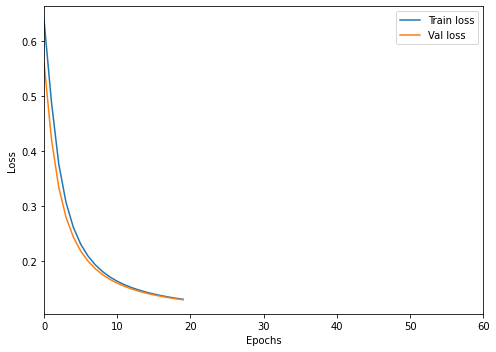

In [10]:
plt.figure(figsize=(7,5))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 60)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))